In [375]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import contextily as cx
import xgboost as xgb
import shap
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Add SHELDUS, Census, PEP, SVI, and NRI (FEMA Disaster Index) data

In [2]:
data_path = r"F:/LongMig2025/data/"
SHELDUS = pd.read_csv(data_path + "SHELDUS/ORIGINAL.csv")
state   = gpd.read_file(data_path + "Census/usstate/cb_2018_us_state_500k.shp").to_crs('ESRI:102003')
county  = gpd.read_file(data_path + "Census/maincounty/us_conu_county.shp").to_crs('ESRI:102003')
df_pep_2010 = pd.read_csv(data_path + "PEP/co-est2010-alldata.csv", encoding='latin-1')
df_pep_2020 = pd.read_csv(data_path + "PEP/co-est2020-alldata.csv", encoding='latin-1')
SVI_10  = pd.read_csv(data_path + "SVI/SVI_2010_US_county.csv")

SVI_10['FIPS'] = SVI_10['FIPS'].astype("str").str.rjust(5,"0")
state   = state[~state["NAME"].isin(["Alaska","Hawaii","Puerto Rico",
                                   "American Samoa","United States Virgin Islands",
                                   "Guam","Commonwealth of the Northern Mariana Islands"])]
NRI     = pd.read_csv(data_path + "NRI/NRI_Table_Counties/NRI_Table_Counties.csv")

### Add Employment data, Population Density data, GDP data, Amenity data (JanuaryTemp, JanuarySun, JulyTemp, JulyHumid, Topography, and WaterArea (all shown as z-score)) ,and House Price data

In [145]:
Employment = pd.read_csv(data_path + "Unemployment.csv")
PopDensity = pd.read_csv(data_path + "POPDen/PopDensity.csv")
# HPI        = pd.read_csv(data_path + "HPI/hpi_master.csv")
house_price= pd.read_csv(data_path + "Zillow/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
GDP        = pd.read_csv(data_path + "GDP/CAGDP1_ALL_AREAS_2001_2023.csv",  encoding='latin1')
Amenity    = pd.read_csv(data_path + "Amenity/Natural-Amenities-by-U.S.-County.csv")

### Process of PEP data

In [133]:
df_pep_2010["state"] = df_pep_2010["STATE"].astype('int64').astype('str').str.rjust(2, "0")
df_pep_2010["county"] = df_pep_2010["COUNTY"].astype('int64').astype('str').str.rjust(3, "0")
df_pep_2010["FIPS"] = df_pep_2010["state"] + df_pep_2010["county"]

df_pep_2020["state"] = df_pep_2020["STATE"].astype('int64').astype('str').str.rjust(2, "0")
df_pep_2020["county"] = df_pep_2020["COUNTY"].astype('int64').astype('str').str.rjust(3, "0")
df_pep_2020["FIPS"] = df_pep_2020["state"] + df_pep_2020["county"]

In [134]:
df_pep_0120 = pd.merge(df_pep_2010,df_pep_2020,on="FIPS")

### Process of FEMA Disaster Index
Disaster selections: Drought, Cold Wave, Heat Wave, Hurricane, Riverine Flooding, Wildfire, and Winter Weather

Assessing population change in the CONUS from 2000 to 2020 in relation to climate hazard exposure

In [225]:
NRI_CONUS = NRI[~NRI["STATEFIPS"].isin([2, 15, 72, 78, 66, 60, 69])].reset_index(drop=True)
NRI_CONUS["FIPS"] = NRI_CONUS["NRI_ID"].str.extract('(\d{5})')
columns_sel_NRI = ["FIPS","STATEABBRV","STATEFIPS","COUNTY","RISK_SCORE","RISK_RATNG","RISK_SPCTL",
                    "CWAV_EVNTS","CWAV_AFREQ","CWAV_RISKS","CWAV_RISKR", #Cold Wave
                    "DRGT_EVNTS","DRGT_AFREQ","DRGT_RISKS","DRGT_RISKR", #Drought
                    "HWAV_EVNTS","HWAV_AFREQ","HWAV_RISKS","HWAV_RISKR", #Heat Wave
                    "HRCN_EVNTS","HRCN_AFREQ","HRCN_RISKS","HRCN_RISKR", #Hurricane
                    "RFLD_EVNTS","RFLD_AFREQ","RFLD_RISKS","RFLD_RISKR", #Riverine Flooding
                    "WFIR_EVNTS","WFIR_AFREQ","WFIR_RISKS","WFIR_RISKR", #Wildfire
                    "WNTW_EVNTS","WNTW_AFREQ","WNTW_RISKS","WNTW_RISKR"] #Winter Weather
                   # EVNTS:Number of Events, AFREQ:Annualized Frequency,RISKS/R: RISK Score/Rating
NRI_CONUS = NRI_CONUS[columns_sel_NRI]        

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\xiang11\AppData\Local\Temp\ipykernel_6996\1938151037.py:2: SyntaxWarning: invalid escape sequence '\d'
  NRI_CONUS["FIPS"] = NRI_CONUS["NRI_ID"].str.extract('(\d{5})')


### Process of Employment data

In [243]:
non_conus_fips_prefixes = ['00','02', '15', '60', '66', '69', '72', '78']  # Alaska, Hawaii, and island territories
Employment['FIPS_Code'] = Employment['FIPS_Code'].astype(str).str.rjust(5,"0")
unemployment_rate_data = Employment[~Employment['FIPS_Code'].str.startswith(tuple(non_conus_fips_prefixes))]
unemployment_rate_data = unemployment_rate_data[unemployment_rate_data['Attribute'].str.contains('Unemployment_rate_')]

# Pivot the data to create columns for each year's unemployment rate
unemployment_rate_pivot = unemployment_rate_data.pivot_table(
    index=['FIPS_Code', 'State', 'Area_Name'],
    columns='Attribute',
    values='Value'
).reset_index()
unemployment_rate_pivot = unemployment_rate_pivot.drop(["Unemployment_rate_2021","Unemployment_rate_2022"],axis=1)
# Rename columns to make them easier to work with
unemployment_rate_pivot.columns.name = None  # Remove the column hierarchy
unemployment_rate_pivot.rename(columns=lambda x: x.replace('Unemployment_rate_', '') if 'Unemployment_rate_' in str(x) else x, inplace=True)


def calculate_ratio(row, years):
    # Extract the available unemployment rates for the years
    available_rates = row[years].dropna()
    if len(available_rates) > 1:
        first_rate = available_rates.iloc[0]
        last_rate = available_rates.iloc[-1]
        return ((last_rate - first_rate) / first_rate) * 100
    else:
        return None 

def calculate_average(row, years):
    available_rates = row[years].dropna()
    if len(available_rates) > 0:
        return available_rates.mean()
    else:
        return None  # Return None if no data is available

years = [col for col in unemployment_rate_pivot.columns if col.isdigit()]

unemployment_rate_pivot['ratio_une'] = unemployment_rate_pivot.apply(calculate_ratio, axis=1, years=years)
unemployment_rate_pivot['average_rate_une'] = unemployment_rate_pivot.apply(calculate_average, axis=1, years=years)
unemployment_rate_pivot['FIPS'] = unemployment_rate_pivot['FIPS_Code']

### Process of Pop Density

In [120]:
PopDensity_CONUS = PopDensity[~(PopDensity["STATE"] == 2)]
PopDensity_CONUS = PopDensity_CONUS[~(PopDensity_CONUS["STATE"] == 15)]
PopDensity_CONUS["FIPS"] = PopDensity_CONUS['GEOID10'].astype(str).str.rjust(5,"0")
PopDensity_CONUS_sel = PopDensity_CONUS[["FIPS","POPDENS10"]]

### Process of House Price

In [246]:
house_price['StateCodeFIPS'] = house_price['StateCodeFIPS'].astype(str).str.zfill(2)
house_price['MunicipalCodeFIPS'] = house_price['MunicipalCodeFIPS'].astype(str).str.zfill(3)
house_price['FIPS'] = house_price['StateCodeFIPS'] + house_price['MunicipalCodeFIPS']

monthly_columns = [col for col in house_price.columns if '-' in col and len(col.split('-')[0]) == 4]

monthly_data = house_price[['FIPS'] + monthly_columns].copy()
monthly_data = monthly_data.melt(id_vars=['FIPS'], var_name='date', value_name='price')
monthly_data['date'] = pd.to_datetime(monthly_data['date'])
monthly_data['year'] = monthly_data['date'].dt.year

annual_prices = monthly_data.groupby(['FIPS', 'year'])['price'].mean().reset_index()

annual_prices_pivot = annual_prices.pivot(index='FIPS', columns='year', values='price').reset_index()

def calculate_ratio(row):
    available_years = row[annual_price_columns].dropna()
    if len(available_years) > 1:
        first_year = available_years.index[0]
        last_year = available_years.index[-1]
        return ((available_years[last_year] - available_years[first_year]) / available_years[first_year]) * 100
    return None 

def calculate_average(row):
    available_years = row[annual_price_columns].dropna()
    if len(available_years) > 0:
        return available_years.mean()
    return None  # Return None if no data is available

annual_price_columns = [col for col in annual_prices_pivot.columns if isinstance(col, int)]

annual_prices_pivot['ratio_HP'] = annual_prices_pivot.apply(calculate_ratio, axis=1)
annual_prices_pivot['average_HP'] = annual_prices_pivot.apply(calculate_average, axis=1)

annual_prices_pivot_cleaned = annual_prices_pivot.dropna(subset=annual_price_columns, how='all')

non_conus_fips_prefixes = ['02', '15', '60', '66', '69', '72', '78']  # Alaska, Hawaii, and island territories

annual_prices_pivot_cleaned['FIPS'] = annual_prices_pivot_cleaned['FIPS'].astype(str)
conus_annual_prices = annual_prices_pivot_cleaned[
    ~annual_prices_pivot_cleaned['FIPS'].str[:2].isin(non_conus_fips_prefixes)
]

### Process GDP data

In [242]:
population_data = df_pep_0120
gdp_data = GDP

gdp_data['GeoFIPS'] = gdp_data['GeoFIPS'].str.strip('" "').str.zfill(5)
non_conus_fips_prefixes = ['02', '15', '60', '66', '69', '72', '78', '91', '92', '93', '94', '95', '96', '97', '98']  # Alaska, Hawaii, and territories
gdp_data_filtered = gdp_data[~gdp_data['GeoFIPS'].str.startswith(tuple(non_conus_fips_prefixes))]
gdp_data_filtered = gdp_data[
    ~gdp_data['GeoFIPS'].str[:2].isin(non_conus_fips_prefixes) & (gdp_data['GeoFIPS'] != '00000')
]
gdp_data_filtered["GeoFIPS"] = gdp_data_filtered["GeoFIPS"].str.extract('(\d{5})')
gdp_data_filtered = gdp_data_filtered.dropna(subset=["GeoFIPS"])
# Step 2: Retain only "Real GDP" rows
gdp_data_real_gdp = gdp_data_filtered[gdp_data_filtered['Description'].str.contains("Real GDP", na=False)]

# Step 3: Extract and clean population data
population_columns = [col for col in population_data.columns if col.startswith('POPESTIMATE')]
population_data_cleaned = population_data[['STATE_x', 'COUNTY_x'] + population_columns].copy()
population_data_cleaned['FIPS'] = (
    population_data_cleaned['STATE_x'].astype(str).str.zfill(2) +
    population_data_cleaned['COUNTY_x'].astype(str).str.zfill(3)
)

# Step 4: Ensure numeric data types
gdp_years = [col for col in gdp_data_real_gdp.columns if col.isdigit()]
for year in gdp_years:
    gdp_data_real_gdp[year] = pd.to_numeric(gdp_data_real_gdp[year], errors='coerce')

for col in population_columns:
    population_data_cleaned[col] = pd.to_numeric(population_data_cleaned[col], errors='coerce')

# Step 5: Merge GDP and population data
merged_data = gdp_data_real_gdp.merge(population_data_cleaned, left_on='GeoFIPS', right_on='FIPS', how='inner')

# Step 6: Calculate GDP per capita for each year
available_gdp_years = [year for year in gdp_years if f'POPESTIMATE{year}' in merged_data.columns]
for year in available_gdp_years:
    merged_data[f'GDP_per_capita_{year}'] = (
        merged_data[year] * 1000 / merged_data[f'POPESTIMATE{year}']
    )

# Step 7: Calculate change ratio and average GDP per capita
def calculate_ratio(row):
    available_data = row[[f'GDP_per_capita_{year}' for year in available_gdp_years]].dropna()
    if len(available_data) > 1:
        first_year = available_data.index[0]
        last_year = available_data.index[-1]
        return ((available_data[last_year] - available_data[first_year]) / available_data[first_year]) * 100
    return None

def calculate_average(row):
    available_data = row[[f'GDP_per_capita_{year}' for year in available_gdp_years]].dropna()
    if len(available_data) > 0:
        return available_data.mean()
    return None

merged_data['ratio'] = merged_data.apply(calculate_ratio, axis=1)
merged_data['average'] = merged_data.apply(calculate_average, axis=1)

# Step 8: Select final columns and display the result
final_columns = ['FIPS', 'GeoName'] + [f'GDP_per_capita_{year}' for year in available_gdp_years] + ['ratio', 'average']
GDP_final_data = merged_data[final_columns]
GDP_final_data["ratio_GDP"] = GDP_final_data["ratio"]

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\xiang11\AppData\Local\Temp\ipykernel_6996\1625967566.py:10: SyntaxWarning: invalid escape sequence '\d'
  gdp_data_filtered["GeoFIPS"] = gdp_data_filtered["GeoFIPS"].str.extract('(\d{5})')
C:\Users\xiang11\AppData\Local\Temp\ipykernel_6996\1625967566.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_data_filtered["GeoFIPS"] = gdp_data_filtered["GeoFIPS"].str.extract('(\d{5})')
C:\Users\xiang11\AppData\Local\Temp\ipykernel_6996\1625967566.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

### Process of Amenity data

In [168]:
Amenity_sel = Amenity[["FIPS","LogWater","JanuaryTempZ","JanuarySunZ","JulyTempZ","JulyHumidZ","TopographyZ","WaterAreaZ","NaturalAmenityScale","NaturalAmenityTier","NaturalAmenityRank"]]
Amenity_sel["FIPS"] = Amenity_sel['FIPS'].astype(str).str.rjust(5,"0")

C:\Users\xiang11\AppData\Local\Temp\ipykernel_6996\1981708956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amenity_sel["FIPS"] = Amenity_sel['FIPS'].astype(str).str.rjust(5,"0")


### Compute Net Migration Rate (NMR)

In [170]:
correct_netmig_columns = []
for year in range(2001, 2021):
    column_name_x = f'RNETMIG{year}_x'
    column_name_y = f'RNETMIG{year}_y'
    column_name = f'RNETMIG{year}'
    if column_name in df_pep_0120.columns:
        correct_netmig_columns.append(column_name)
    elif column_name_x in df_pep_0120.columns:
        correct_netmig_columns.append(column_name_x)
    elif column_name_y in df_pep_0120.columns:
        correct_netmig_columns.append(column_name_y)

In [171]:
df_pep_0120["NetMigrationRateTotal"] = df_pep_0120[correct_netmig_columns].mean(axis=1)
df_pep_0120_used = df_pep_0120[['FIPS','STNAME_x', 'CTYNAME_x', 'NetMigrationRateTotal']]

In [172]:
df_NMR = pd.merge(df_pep_0120_used,county,on="FIPS",how="inner")
gdf_NMR = gpd.GeoDataFrame(df_NMR,geometry="geometry")

<Figure size 1000x800 with 0 Axes>

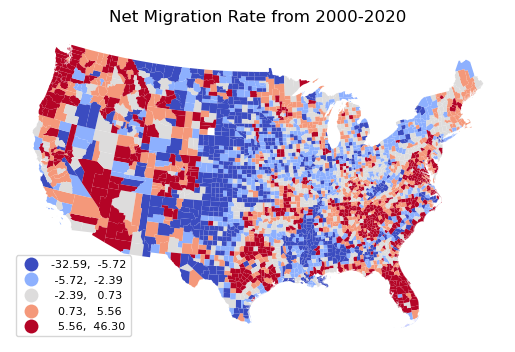

In [188]:
plt.figure(figsize=(10, 8))
gdf_NMR.plot(column="NetMigrationRateTotal",cmap="coolwarm",
             scheme="quantiles",
#              scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,legend_kwds={
        "fontsize": 8,  # Adjust font size for smaller text
        "loc": "lower left",  # Position the legend
    })
plt.title("Net Migration Rate from 2000-2020")
plt.axis('off')
plt.show()

### Map the disaster risk

In [193]:
df_NRI = pd.merge(NRI_CONUS,county,on="FIPS",how="inner")
gdf_NRI = gpd.GeoDataFrame(df_NRI,geometry="geometry")

In [207]:
risk_columns = [col for col in gdf_NRI.columns if 'RISKS' in col]

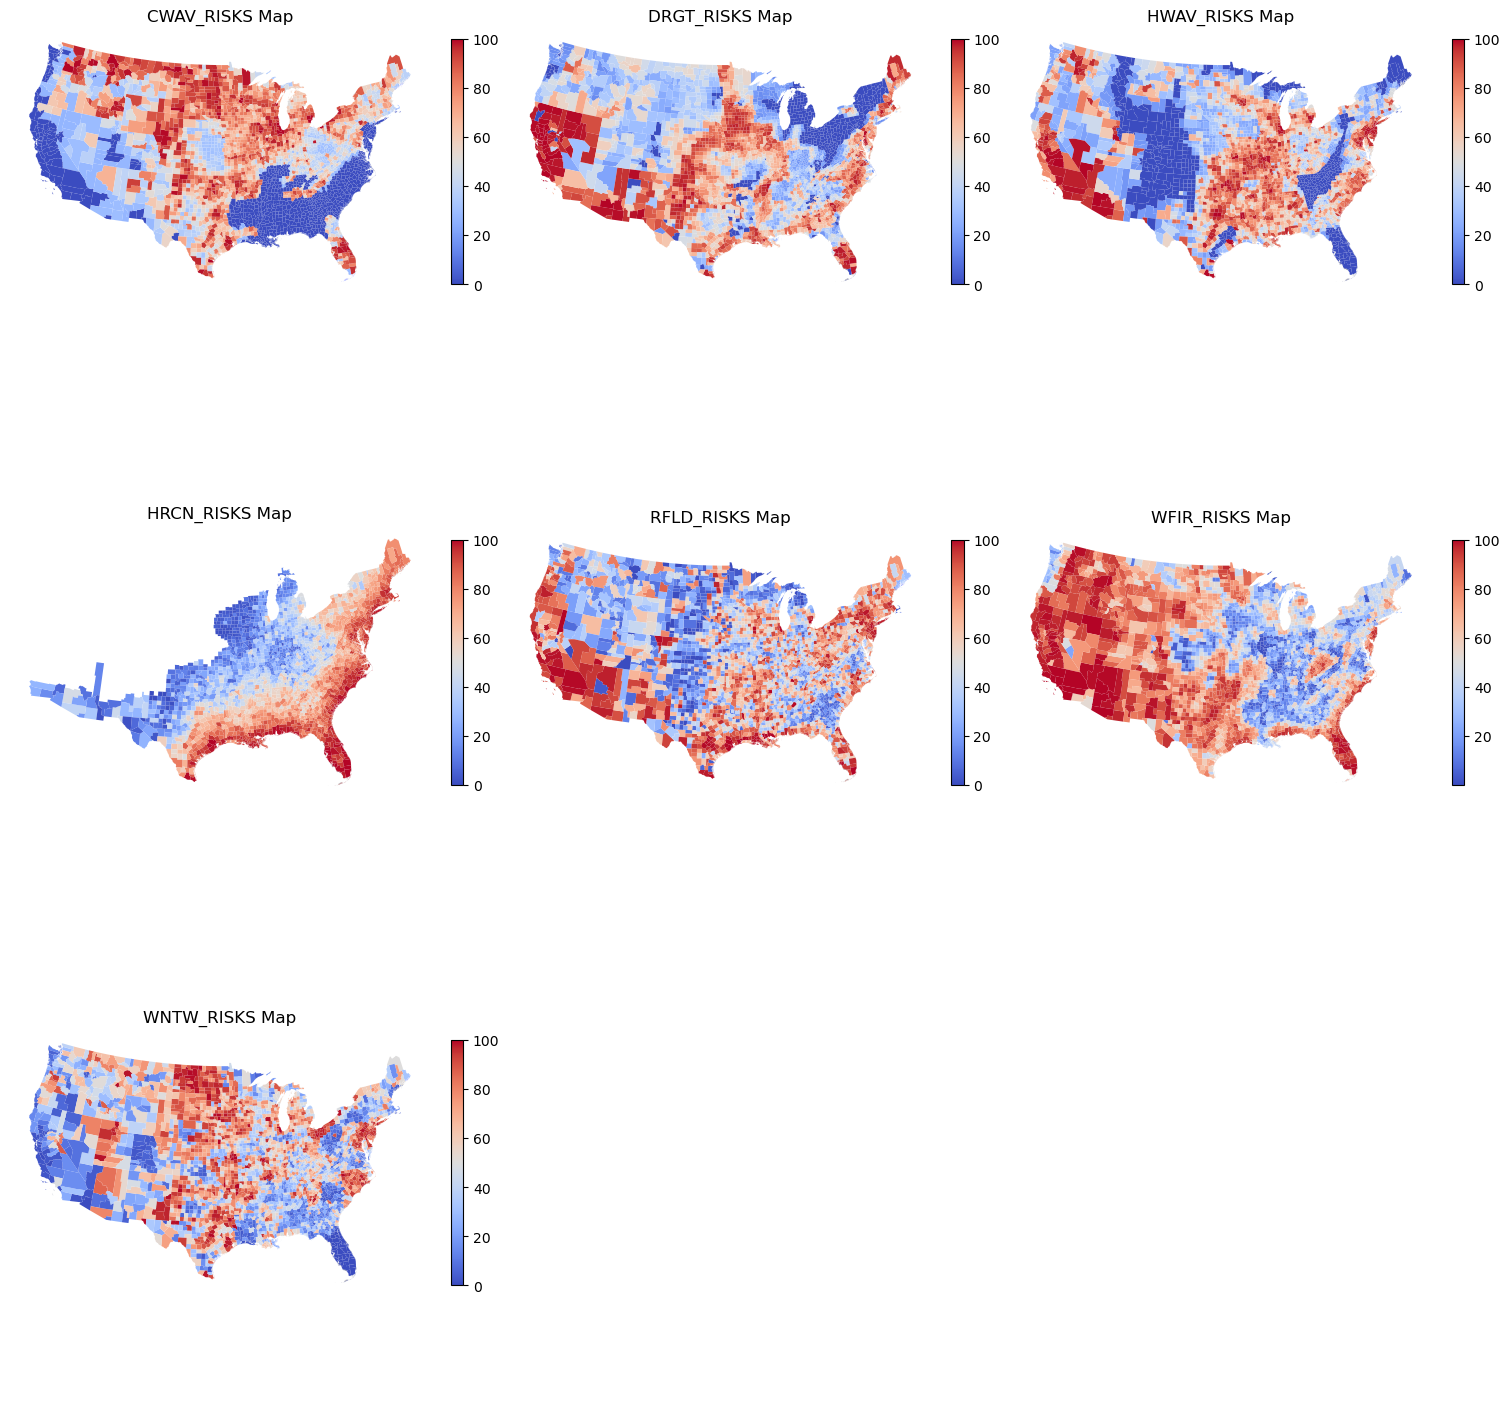

In [212]:
# Create subplots for the maps
num_risks = len(risk_columns)
cols = 3  # Number of columns for the subplots
rows = (num_risks + cols - 1) // cols  # Calculate rows based on the number of risks

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each map in a subplot
for i, risk in enumerate(risk_columns):
    gdf_NRI.plot(
        column=risk,
        cmap='coolwarm',
        legend=True,
        ax=axes[i],
        legend_kwds={'shrink': 0.5},  # Shrink legend to fit subplot
    )
    axes[i].set_title(f'{risk} Map', fontsize=12)
    axes[i].axis('off')  # Turn off axis

# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Show the figure
plt.show()

### Combine each dataset

In [250]:
Regression_data = pd.DataFrame()
Regression_data = df_pep_0120
Regression_data = pd.merge(Regression_data,SVI_10,on="FIPS",how="inner")
Regression_data = pd.merge(Regression_data,NRI_CONUS,on="FIPS",how="inner")
Regression_data = pd.merge(Regression_data,unemployment_rate_pivot,on="FIPS",how="inner")
Regression_data = pd.merge(Regression_data,PopDensity_CONUS_sel,on="FIPS",how="inner")
Regression_data = pd.merge(Regression_data,conus_annual_prices,on="FIPS",how="inner")
Regression_data = pd.merge(Regression_data,GDP_final_data,on="FIPS",how="inner")
Regression_data = pd.merge(Regression_data,Amenity_sel,on="FIPS",how="inner")

In [255]:
used_list = [
    "FIPS","NetMigrationRateTotal",#PEP
    "E_P_POV","E_P_UNEMP","E_P_PCI","E_P_NOHSDIP","P_AGE65","P_AGE17","P_SNGPRNT",
    "P_MINORITY","E_P_LIMENG","E_P_MUNIT","E_P_MOBILE","E_P_CROWD","E_P_NOVEH","P_GROUPQ", #SVI
    "CWAV_RISKS","DRGT_RISKS","HWAV_RISKS","HRCN_RISKS","RFLD_RISKS","WFIR_RISKS","WNTW_RISKS",#RISK SCORE
#     "average_rate_une",#Unemployment
    "POPDENS10",#POP DENSITY
    "ratio_HP",#House Price
    "ratio_GDP",#GDP
    'JanuaryTempZ', 'JanuarySunZ', 'JulyTempZ','JulyHumidZ', 'TopographyZ', 'WaterAreaZ' #Amenity
]
zscore_list = ["E_P_POV","E_P_UNEMP","E_P_PCI","E_P_NOHSDIP","P_AGE65","P_AGE17","P_SNGPRNT",
    "P_MINORITY","E_P_LIMENG","E_P_MUNIT","E_P_MOBILE","E_P_CROWD","E_P_NOVEH","P_GROUPQ", #SVI
    "CWAV_RISKS","DRGT_RISKS","HWAV_RISKS","HRCN_RISKS","RFLD_RISKS","WFIR_RISKS","WNTW_RISKS",#RISK SCORE
#     "average_rate_une",#Unemployment
    "POPDENS10",#POP DENSITY
    "ratio_HP",#House Price
    "ratio_GDP"]#GDP
name_list = [
    "FIPS","NMR",
    "%BelowPoverty","%Unemployed","PerCapitaIncome","%NoHighSchoolDiploma25+","%Age65+",
    "%Age18-","%Single-parent household","%Minority","%Age5+LessThanWellEnglish",
    "%Multi-Unit House","%MobileHome","%HousePop>Room","%NoVehicleHousehold","%GroupQuarters",
    "Cold Wave Risk", "Drought Risk","Heat Wave Risk","Hurricane Risk","Flood Risk","Wildfire Risk","Winter Weather Risk",
    "Pop Density","%Change of House Price","%Change of GDP per capita",
    "Jan Temp","Jan Sun","July Temp","July Humid","Topography","Water Area"
]

In [271]:
Regression_data_used = Regression_data[used_list]
Regression_data_used[zscore_list] = (Regression_data_used[zscore_list] - Regression_data_used[zscore_list].mean()) / Regression_data_used[zscore_list].std()
Regression_data_used.columns = name_list

C:\Users\xiang11\AppData\Local\Temp\ipykernel_6996\2705445393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Regression_data_used[zscore_list] = (Regression_data_used[zscore_list] - Regression_data_used[zscore_list].mean()) / Regression_data_used[zscore_list].std()


### XGBOOST with all factors

Mean Squared Error: 29.238896600681553


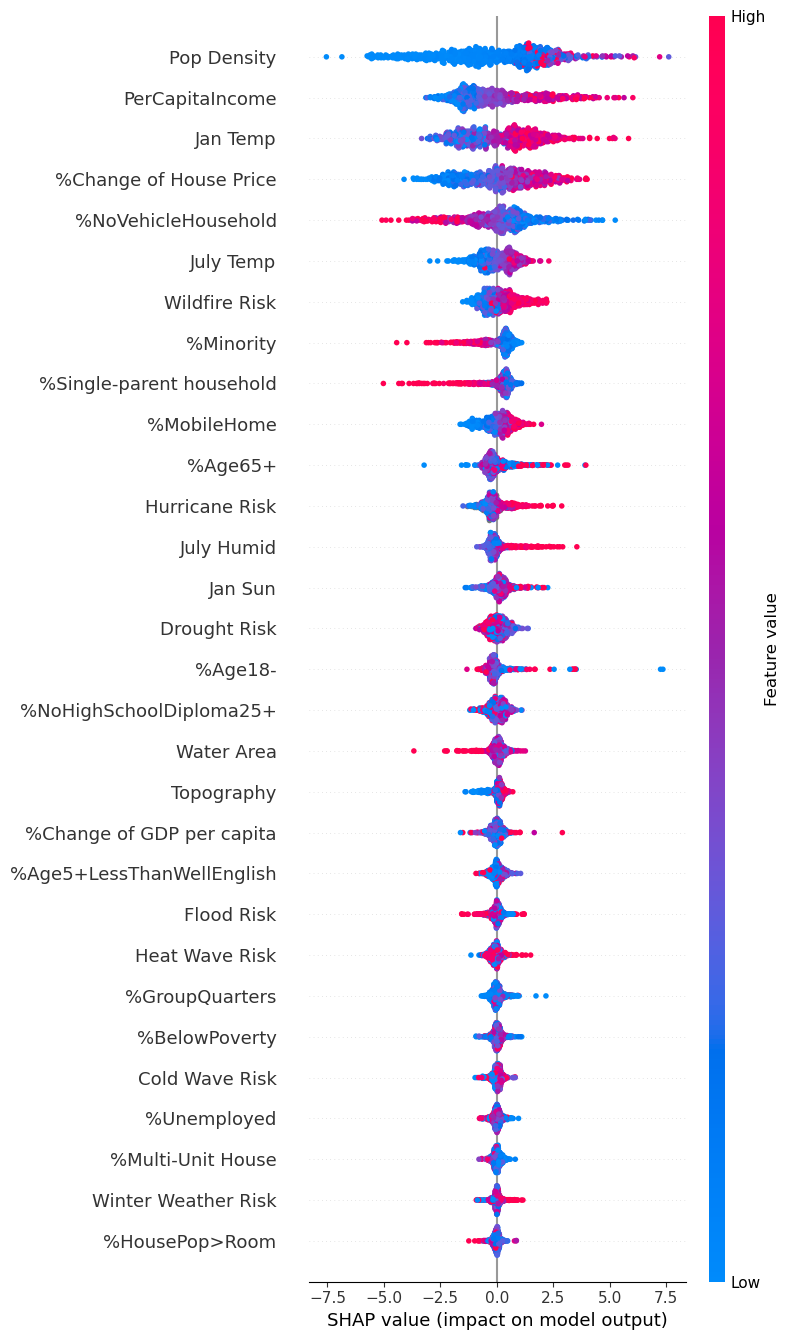

In [426]:
X = Regression_data_used.drop(columns=['NMR', 'FIPS'])
y = Regression_data_used['NMR']

# # Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# # Train an XGBoost regression model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Explain the model with SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test,max_display=100)

In [427]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MSE: 29.238896600681553
RMSE: 5.407300306130736
R2: 0.5569271272299465


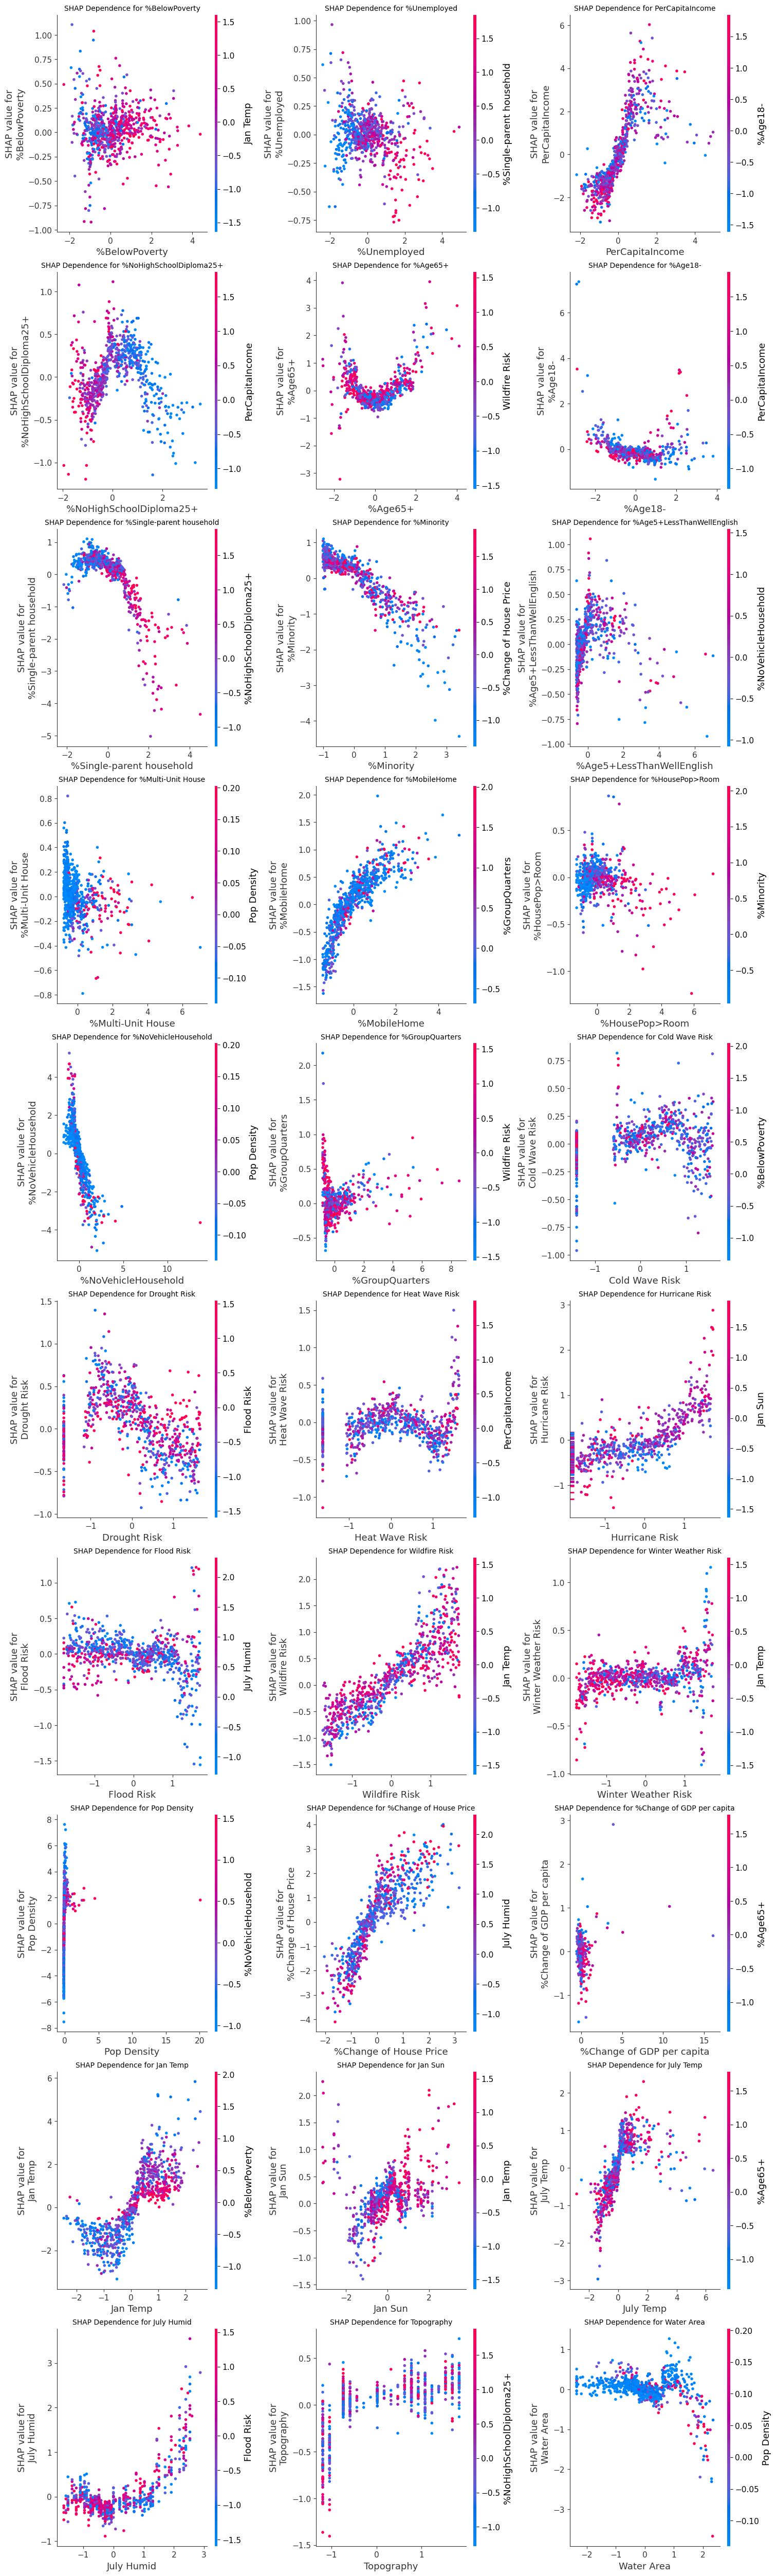

In [428]:
# Define all the features in your dataset
all_features = X_test.columns  # Replace with the features from your test set

# Set up the number of rows and columns for subplots
num_features = len(all_features)
cols = 3  # Number of columns in the subplot grid
rows = (num_features + cols - 1) // cols  # Calculate the number of rows needed

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate SHAP dependence plots for each feature
for i, feature in enumerate(all_features):
    shap.dependence_plot(
        feature, shap_values.values, X_test, ax=axes[i], show=False
    )
    axes[i].set_title(f"SHAP Dependence for {feature}", fontsize=10)
    

# Turn off unused subplots if the number of features is less than total subplots
for j in range(len(all_features), len(axes)):
    axes[j].axis("off")

# Show the final figure
plt.show()


### XGBOOST with only disaster factors

Mean Squared Error: 50.79767038985043


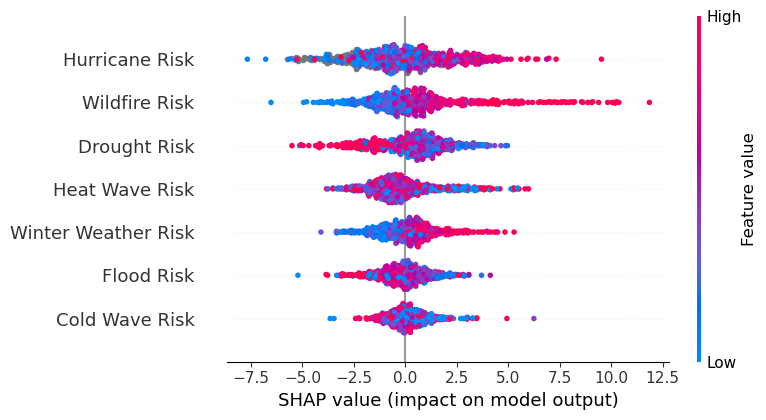

In [429]:
X = Regression_data_used[["Cold Wave Risk", "Drought Risk","Heat Wave Risk","Hurricane Risk","Flood Risk","Wildfire Risk","Winter Weather Risk"]]
y = Regression_data_used['NMR']

# # Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# # Train an XGBoost regression model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Explain the model with SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test,max_display=100)

In [430]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MSE: 50.79767038985043
RMSE: 7.127248444515628
R2: 0.2302353246417419


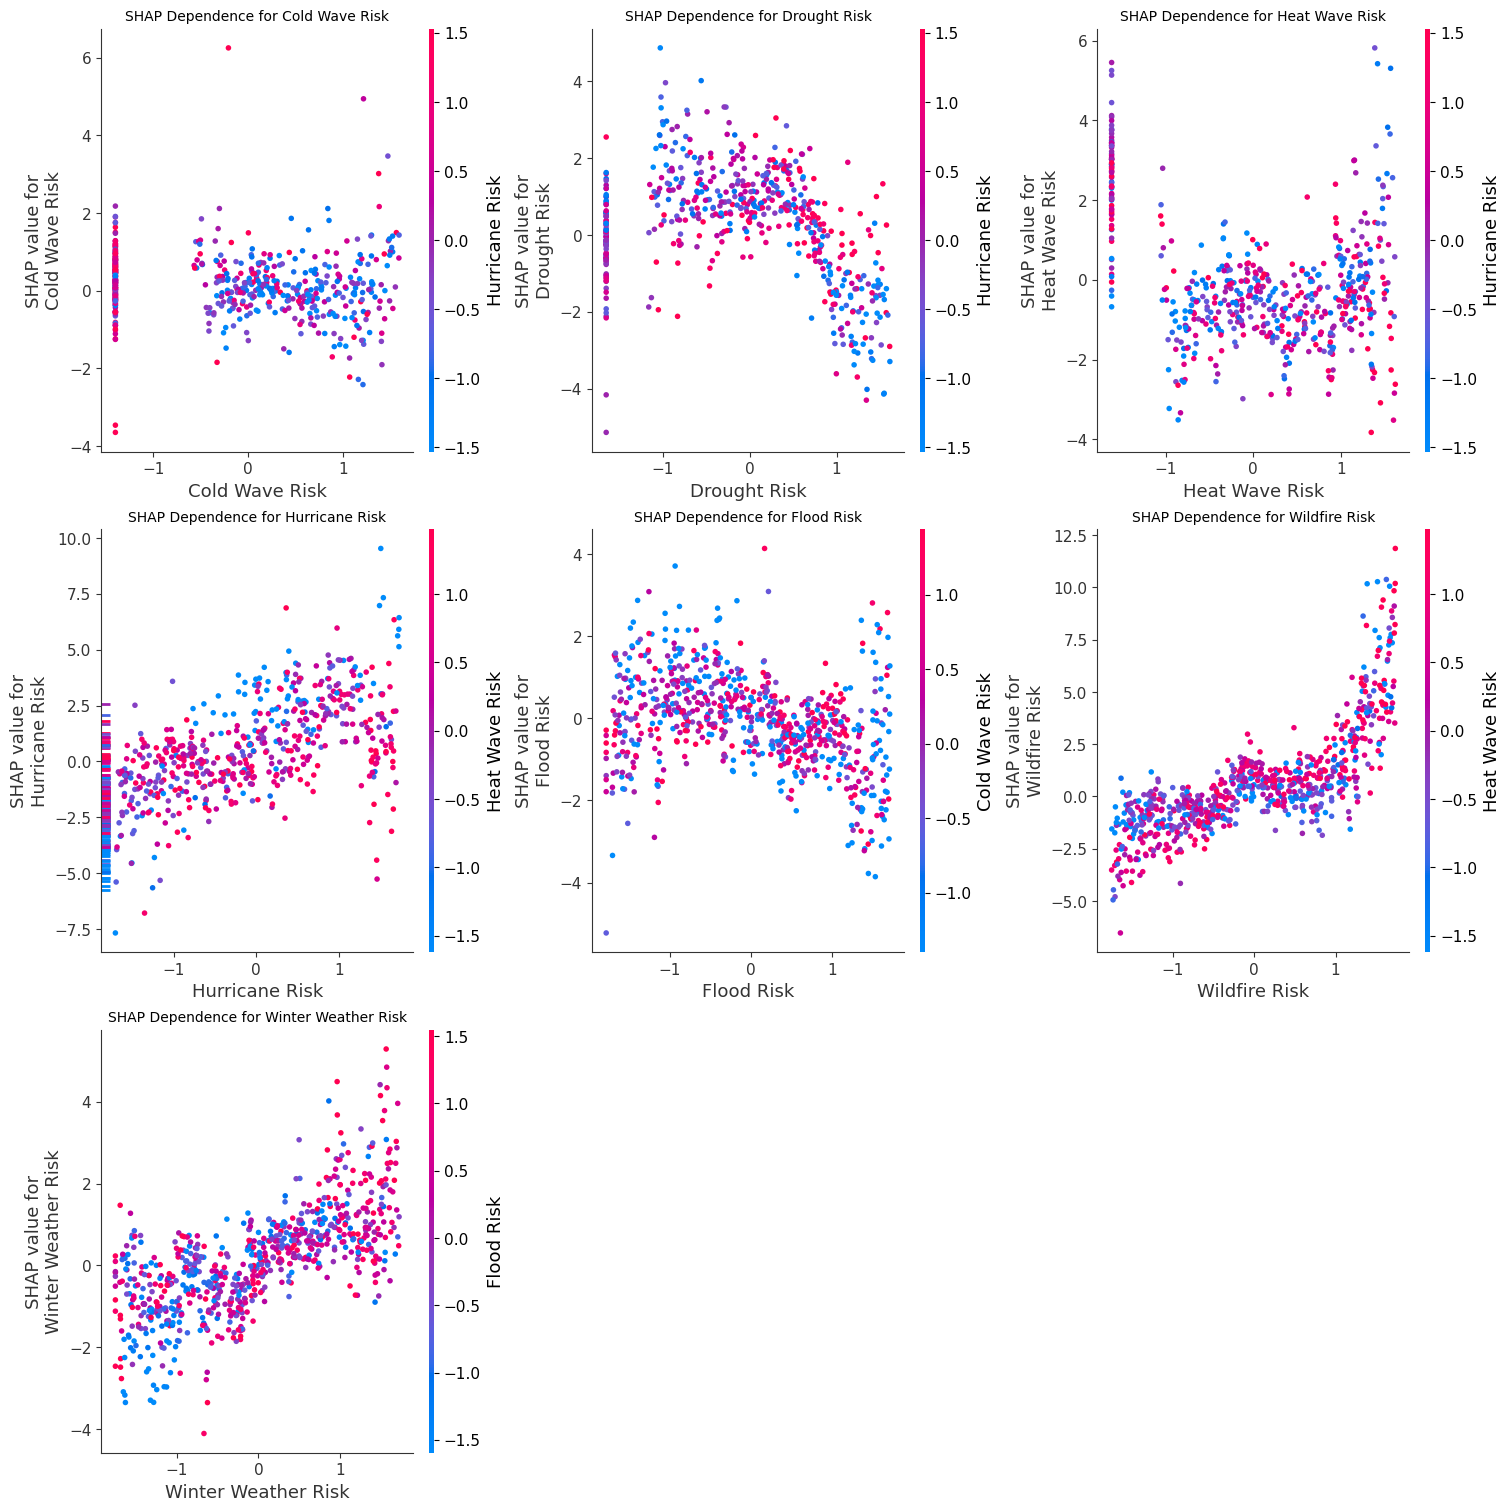

In [431]:
# Define all the features in your dataset
all_features = X_test.columns  # Replace with the features from your test set

# Set up the number of rows and columns for subplots
num_features = len(all_features)
cols = 3  # Number of columns in the subplot grid
rows = (num_features + cols - 1) // cols  # Calculate the number of rows needed

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate SHAP dependence plots for each feature
for i, feature in enumerate(all_features):
    shap.dependence_plot(
        feature, shap_values.values, X_test, ax=axes[i], show=False
    )
    axes[i].set_title(f"SHAP Dependence for {feature}", fontsize=10)
    

# Turn off unused subplots if the number of features is less than total subplots
for j in range(len(all_features), len(axes)):
    axes[j].axis("off")

# Show the final figure
plt.show()


### Time Series Analysis

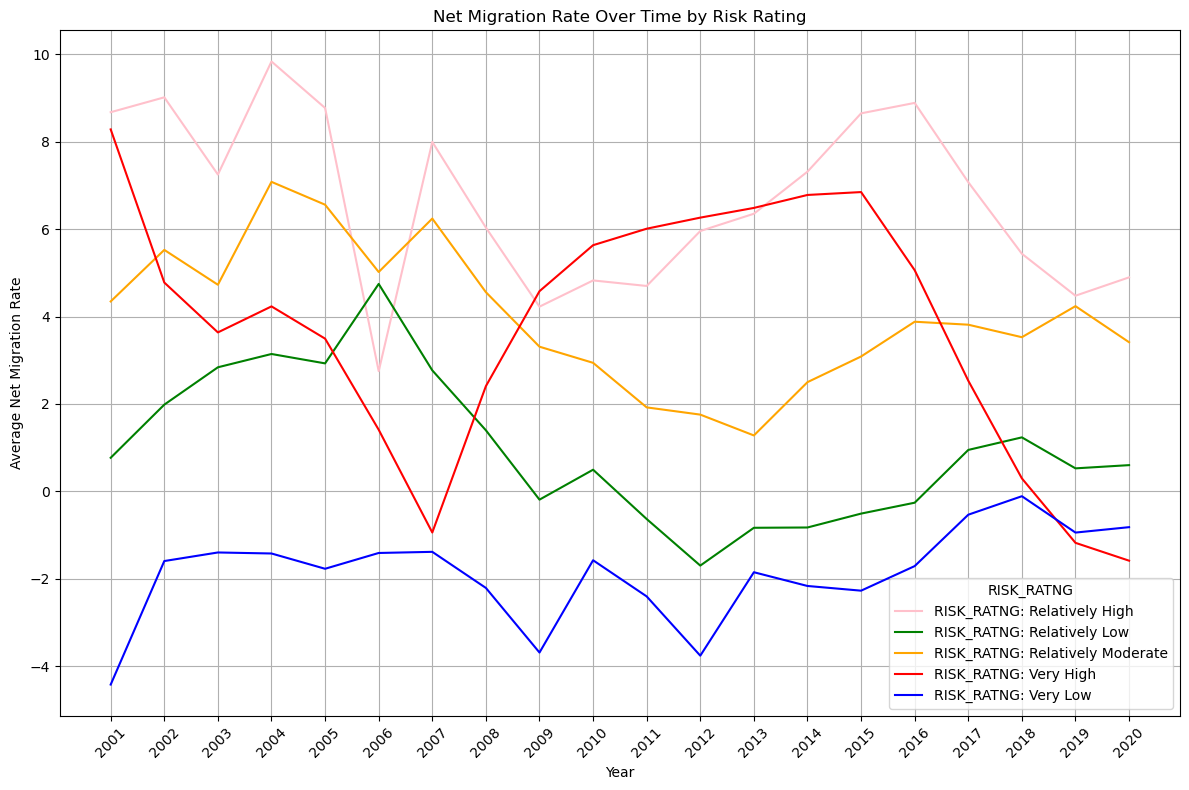

In [425]:
Regression_data1 = Regression_data
Regression_data1.columns = Regression_data1.columns.astype(str)
# Extract relevant columns for net migration rates
migration_columns = [col for col in Regression_data1.columns if col.startswith('RNETMIG')]

# Ensure RISK_RATNG is a string column for grouping
Regression_data1['RISK_RATNG'] = Regression_data1['RISK_RATNG'].astype(str)

# Group data by RISK_RATNG and calculate the mean net migration rate for each year
migration_groups = Regression_data1.groupby('RISK_RATNG')[migration_columns].mean()
colors = {"Relatively High": "pink", "Relatively Low":"green", "Relatively Moderate": "orange","Very High":"red", "Very Low": "blue"}
# Extract years from the column names
years = [int(col.replace('RNETMIG', '')) for col in migration_columns]

# Plot the line chart for each RISK_RATNG group
plt.figure(figsize=(12, 8))
for risk_rating in migration_groups.index:
    plt.plot(
        years,  # Use years on the x-axis
        migration_groups.loc[risk_rating],
        label=f'RISK_RATNG: {risk_rating}',
        color=colors[risk_rating]
    )

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.title('Net Migration Rate Over Time by Risk Rating')
plt.xticks(years, rotation=45)  # Rotate year labels for better readability
plt.legend(title='RISK_RATNG')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


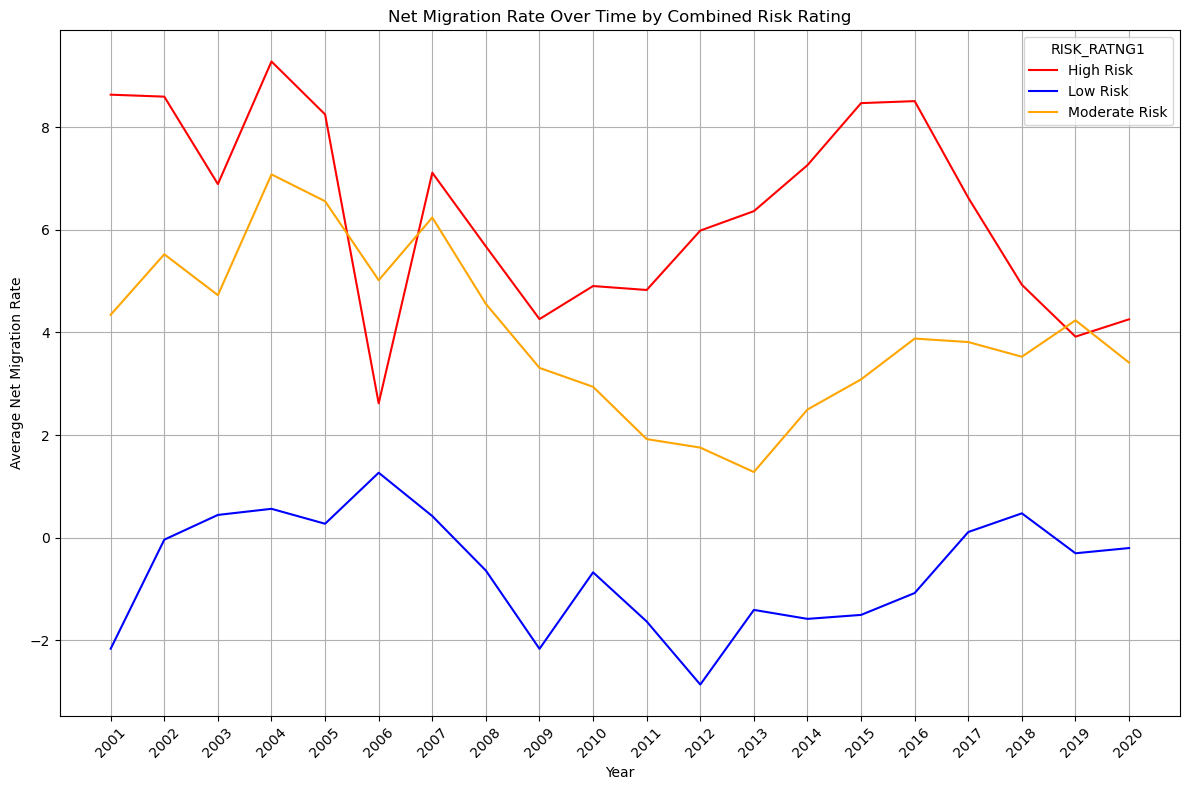

In [422]:
# Map RISK_RATNG categories to new groups
risk_mapping = {
    "Relatively High": "High",
    "Very High": "High",
    "Relatively Low": "Low",
    "Very Low": "Low",
    "Relatively Moderate": "Moderate"
}
Regression_data1['RISK_RATNG1'] = Regression_data1['RISK_RATNG'].map(risk_mapping)

# Extract relevant columns for net migration rates
migration_columns = [col for col in Regression_data1.columns if col.startswith('RNETMIG')]

# Group data by the new RISK_RATNG categories and calculate the mean net migration rate for each year
combined_risk_groups = Regression_data1.groupby('RISK_RATNG1')[migration_columns].mean()

colors = {"High": "red", "Moderate": "orange", "Low": "blue"}
# Extract years from the column names
years = [int(col.replace('RNETMIG', '')) for col in migration_columns]

# Plot the line chart for each combined RISK_RATNG group
plt.figure(figsize=(12, 8))
for risk_rating in combined_risk_groups.index:
    plt.plot(
        years,  # Use years on the x-axis
        combined_risk_groups.loc[risk_rating],
        label=f'{risk_rating} Risk',
        color=colors[risk_rating]
    )

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.title('Net Migration Rate Over Time by Combined Risk Rating')
plt.xticks(years, rotation=45)  # Rotate year labels for better readability
plt.legend(title='RISK_RATNG1')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


"CWAV_RISKR","DRGT_RISKR","HWAV_RISKR","RFLD_RISKR","WFIR_RISKR","WNTW_RISKR"

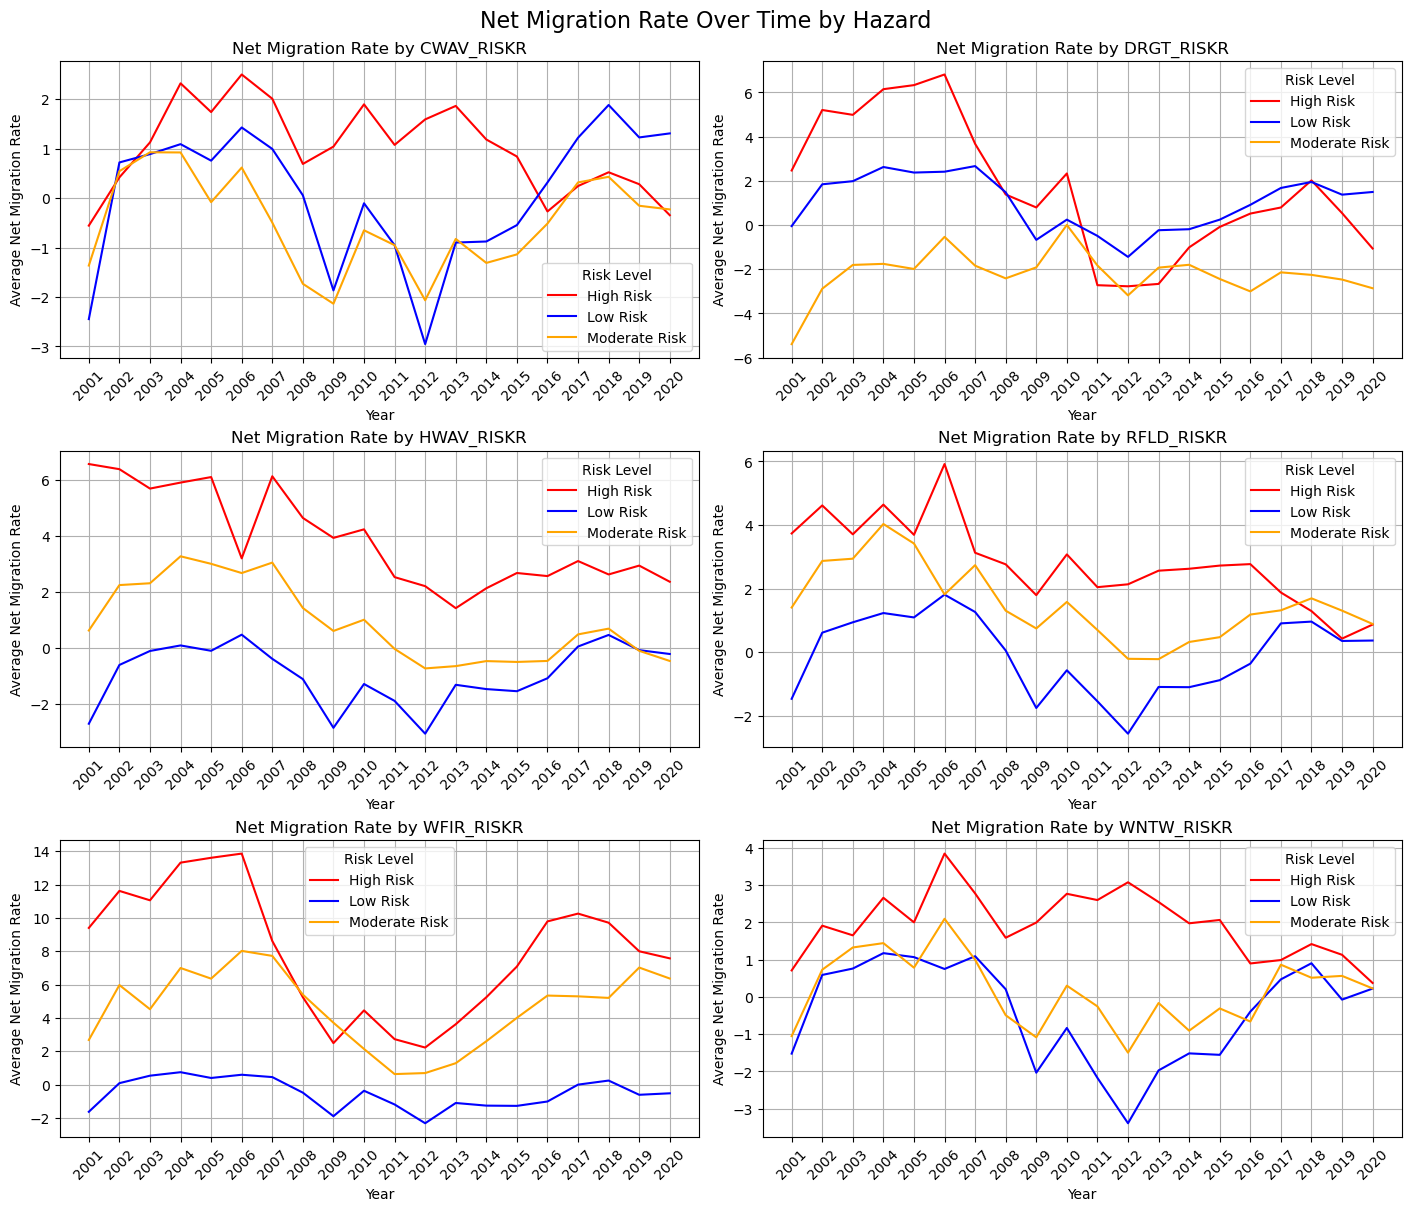

In [423]:
risk_columns = ["CWAV_RISKR","DRGT_RISKR","HWAV_RISKR","RFLD_RISKR","WFIR_RISKR","WNTW_RISKR"]
mapping = {
    "Relatively High": "High",
    "Very High": "High",
    "Relatively Low": "Low",
    "Very Low": "Low",
    "Relatively Moderate": "Moderate",
    "No Rating": None
}
# Create new columns with reclassified values
for col in risk_columns:
    new_col = f"{col}1"
    Regression_data1[new_col] = Regression_data1[col].map(mapping)
    Regression_data1[new_col] = Regression_data1[new_col].astype(str)
    
# Extract year columns for net migration rates
year_columns = [col for col in Regression_data1.columns if col.startswith('RNETMIG')]

# Extract years from the column names
years = [int(col.replace('RNETMIG', '')) for col in year_columns]

colors = {"High": "red", "Moderate": "orange", "Low": "blue"}
# Create subplots for each hazard category
fig, axes = plt.subplots(3, 2, figsize=(14, 12), constrained_layout=True)
axes = axes.flatten()

# Plot each hazard's migration trend grouped by risk levels
for i, col in enumerate(risk_columns):
    new_col = f"{col}1"

    # Filter data to valid risk ratings
    filtered_data = Regression_data1[Regression_data1[new_col].isin(["High", "Moderate", "Low"])]

    # Group by risk levels and calculate mean net migration rate for each year
    grouped_data = filtered_data.groupby(new_col)[year_columns].mean()

    # Plot the line chart
    for risk_rating in grouped_data.index:
        axes[i].plot(
            years, 
            grouped_data.loc[risk_rating], 
            label=f'{risk_rating} Risk',
            color=colors[risk_rating]
        )

    # Customize each subplot
    axes[i].set_title(f"Net Migration Rate by {col}")
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Average Net Migration Rate")
    axes[i].set_xticks(years)
    axes[i].set_xticklabels(years, rotation=45)
    axes[i].legend(title="Risk Level")
    axes[i].grid(True)

# Add overall title
plt.suptitle("Net Migration Rate Over Time by Hazard", fontsize=16)
plt.show()